# Эксперименты для точной настройки (Fine-tuning) chatGPT (OpenAI) на своих данных

**Для примера мы обучим модель** так, чтобы сотрудник компании мог **вводить описание товара в свободной форме** (набирая текст руками или голосовым вводом), модель будет преобразовывать в фиксированных набор параметров (характеристик) в JSON, а затем система преобразует его в форматированную карточку товара в HTML, что может быть полезным инструментом в работе.

Определим фиксированный набор универсальных характеристик для компьютерной техники и периферии. Например, можно использовать следующие 10 характеристик:

1. Название
2. Вес
3. Размер/диагональ
4. Цвет
5. Память/накопитель
6. Процессор
7. Разрешение
8. Порты/интерфейсы
9. Скорость
10. Комментарий

В запросе пользователя могут присутствовать все характеристики, меньше (ставим прочерки в форме) или больше (пишем в поле комментарий).

## Выполняем установку зависимостей

In [ ]:
!pip install openai==1.16.1 tiktoken==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


## Выполняем импорты библиотек

In [ ]:
import openai
import re
import json
import os
import getpass
from datetime import datetime
from openai import OpenAI
import requests
import time
import pandas as pd
from tqdm.notebook import trange, tqdm
from IPython.display import display
from IPython.display import HTML, clear_output

## Подготовка данных

С помощью интерактивного инструмента из ноутбука создал небольшой датасет из 10 примеров и сохранили в JSONL формат.

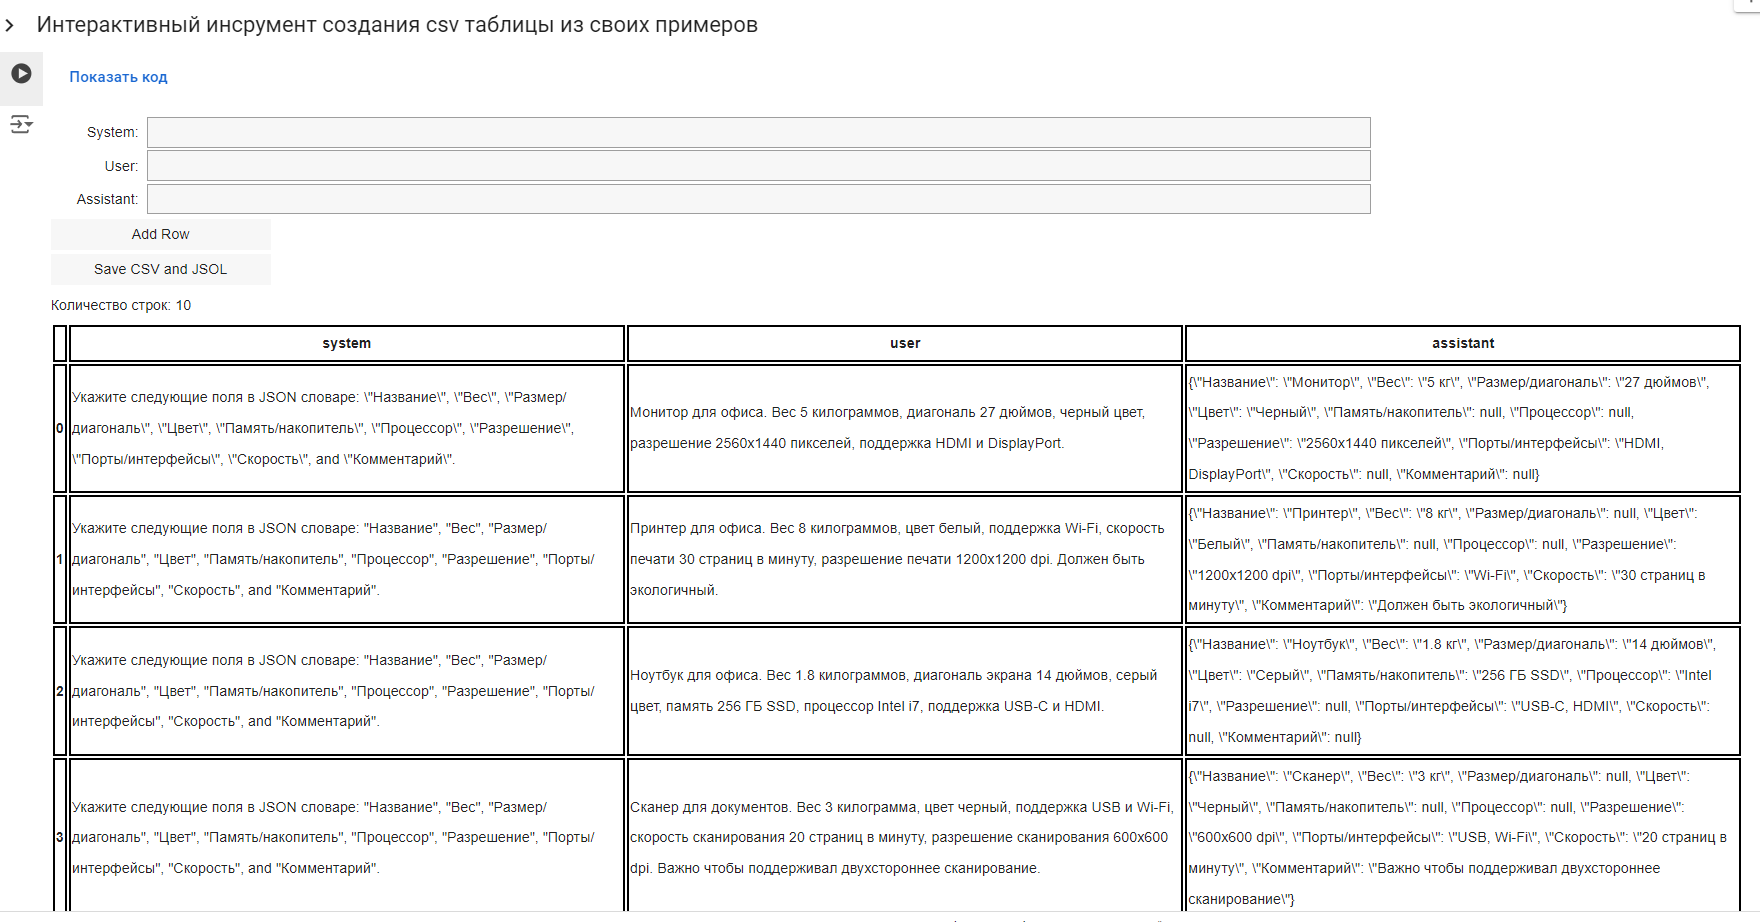

In [ ]:
# Установка ключа OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key и нажмите Enter:")

# Создание клиента OpenAI
client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  # this is also the default, it can be omitted
)

# Функция настройки стиля для переноса текста в выводе ячеек
def set_text_wrap_css():
    css = '''
    <style>
    pre {
        white-space: pre-wrap;
    }
    </style>
    '''
    display(HTML(css))

get_ipython().events.register('pre_run_cell', set_text_wrap_css)

Введите OpenAI API Key и нажмите Enter:··········


## Анализ подготовленных данных для тонкой настройки модели gpt-3.5-turbo https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [ ]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

### Загрузка данных. Сначала мы загружаем набор данных чата из примера файла JSONL .

In [ ]:
data_path = "fine_tune_dataset_dz.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Число примеров:", len(dataset))
print("Первый пример:")
try:
  for message in dataset[0]["messages"]:
      print(message)
except IndexError as e:
  print(f"В датасете нет данных или имеют не верный формат {e}")

Число примеров: 10
Первый пример:
{'role': 'system', 'content': 'Укажите следующие поля в JSON словаре: \\"Название\\", \\"Вес\\", \\"Размер/диагональ\\", \\"Цвет\\", \\"Память/накопитель\\", \\"Процессор\\", \\"Разрешение\\", \\"Порты/интерфейсы\\", \\"Скорость\\", and \\"Комментарий\\".'}
{'role': 'user', 'content': 'Монитор для офиса. Вес 5 килограммов, диагональ 27 дюймов, черный цвет, разрешение 2560x1440 пикселей, поддержка HDMI и DisplayPort.'}
{'role': 'assistant', 'content': '{\\"Название\\": \\"Монитор\\", \\"Вес\\": \\"5 кг\\", \\"Размер/диагональ\\": \\"27 дюймов\\", \\"Цвет\\": \\"Черный\\", \\"Память/накопитель\\": null, \\"Процессор\\": null, \\"Разрешение\\": \\"2560x1440 пикселей\\", \\"Порты/интерфейсы\\": \\"HDMI, DisplayPort\\", \\"Скорость\\": null, \\"Комментарий\\": null}'}


### Проверка формата

Мы можем выполнить различные проверки ошибок, чтобы убедиться, что каждый разговор в наборе данных соответствует формату, ожидаемому API тонкой настройки. Ошибки классифицируются в зависимости от их характера для облегчения отладки.



* **Проверка типа данных** : проверяет, является ли каждая запись в наборе данных словарем ( dict). Тип ошибки: data_type.
* **Наличие списка сообщений** : проверяет, messagesприсутствует ли список в каждой записи. Тип ошибки: missing_messages_list.
* **Проверка ключей сообщений** : проверяет, что каждое сообщение в messagesсписке содержит ключи roleи content. Тип ошибки: message_missing_key.
* **Нераспознанные ключи в сообщениях** : регистрируется, если в сообщении есть ключи, отличные от role, content, weight, function_callи name. Тип ошибки: message_unrecognized_key.
* **Проверка роли** : проверяет, roleявляется ли роль «системой», «пользователем» или «помощником». Тип ошибки: unrecognized_role.
* **Проверка содержимого** : проверяет contentналичие текстовых данных и является строкой. Тип ошибки: missing_content.
* **Наличие сообщения помощника** : проверяет, есть ли в каждом разговоре хотя бы одно сообщение от помощника. Тип ошибки: example_missing_assistant_message.

In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Обнаружены следующие ошибки:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("Ошибок не обнаружено")

Ошибок не обнаружено


### Утилиты для подсчета токенов

#### Функции

In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Распредделение в {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

#### Предупреждения о данных и количество токенов

С помощью легкого анализа мы можем выявить потенциальные проблемы в наборе данных, например пропущенные сообщения, и предоставить статистическую информацию о количестве сообщений и токенов.

*  **Отсутствующие системные/пользовательские сообщения** : подсчитывает количество
разговоров, в которых отсутствует «системное» или «пользовательское» сообщение. Такие сообщения имеют решающее значение для определения поведения помощника и начала разговора.
*  **Количество сообщений в примере** : суммирует распределение количества сообщений в каждом разговоре, предоставляя представление о сложности диалога.
*  **Всего токенов в примере** : рассчитывает и суммирует распределение общего количества токенов в каждом разговоре. Важно для понимания затрат на тонкую настройку.
*  **Токены в сообщениях помощника** : подсчитывает количество токенов в сообщениях помощника за разговор и суммирует это распределение. Полезно для понимания многословности помощника.
*  **Предупреждения о лимите токенов** : проверяется, не превышают ли какие-либо примеры максимальный лимит токенов (4096 токенов), поскольку такие примеры будут усечены во время тонкой настройки, что может привести к потере данных.

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Число примеров отсутствующего системного сообщения:", n_missing_system)
print("Число примеров отсутствующего сообщения пользователя:", n_missing_user)
print_distribution(n_messages, "Распределение количества_сообщений_на_пример")
print_distribution(convo_lens, "Распределение количества_токенов_на_пример")
print_distribution(assistant_message_lens, "Распределение количества_токенов_ассистента_на_пример")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} пример может превышать лимит токенов 4096, они будут усечены во время тонкой настройки")

Число примеров отсутствующего системного сообщения: 0
Число примеров отсутствующего сообщения пользователя: 0

#### Распредделение в Распределение количества_сообщений_на_пример:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Распредделение в Распределение количества_токенов_на_пример:
min / max: 287, 327
mean / median: 307.3, 304.0
p5 / p95: 290.6, 325.2

#### Распредделение в Распределение количества_токенов_ассистента_на_пример:
min / max: 121, 144
mean / median: 132.0, 133.0
p5 / p95: 121.9, 141.3

0 пример может превышать лимит токенов 4096, они будут усечены во время тонкой настройки


#### Оценка затрат

В этом последнем разделе мы оцениваем общее количество токенов, которые будут использоваться для тонкой настройки, что позволяет нам приблизительно оценить стоимость. Стоит отметить, что продолжительность работ по тонкой настройке также будет увеличиваться вместе с количеством токенов.

In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 7
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Набор данных содержит ~{n_billing_tokens_in_dataset} токенов, за которые будет взиматься плата во время обучения.")
print(f"По умолчанию вы будете обучаться в течение {n_epochs} эпох в этом наборе данных.")
print(f"По умолчанию с вас будет взиматься плата за ~{n_epochs * n_billing_tokens_in_dataset} токенов")

Набор данных содержит ~3073 токенов, за которые будет взиматься плата во время обучения.
По умолчанию вы будете обучаться в течение 10 эпох в этом наборе данных.
По умолчанию с вас будет взиматься плата за ~30730 токенов


## Загрузить файл обучения

После проверки данных файл необходимо загрузить с помощью Files API , чтобы его можно было использовать в заданиях по точной настройке:

Этоти фрагмент кода используется для загрузки файла данных в сервис OpenAI с целью последующего дообучения (fine-tuning) модели искусственного интеллекта:

1. **Загрузка файла для дообучения**: Вызывается метод `client.files.create()`, который служит для загрузки файла в OpenAI. Аргументы метода указывают на следующее:
   - `file=open("fine_tune_dataset_dz.jsonl", "rb")` открывает файл `fine_tune_dataset_dz.jsonl` в бинарном режиме (`"rb"`). Этот файл предполагается содержать данные для дообучения модели в формате JSONL, где каждая строка является отдельным JSON объектом.
   - `purpose="fine-tune"` указывает, что файл загружается с целью дообучения модели. Этот параметр важен, поскольку определяет, как OpenAI будет обрабатывать и использовать загруженный файл.

В результате выполнения этого кода файл `fine_tune_dataset_dz.jsonl` загружается в систему OpenAI, где он может быть использован для дообучения существующей модели искусственного интеллекта. Дообучение позволяет модели лучше адаптироваться к конкретным задачам, типам запросов или стилю диалога, основываясь на предоставленных данных.

In [ ]:
client.files.create(
  file=open("fine_tune_dataset_dz.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-TLiH0em1jH65ArglME7bMTiD', bytes=28308, created_at=1715867780, filename='fine_tune_dataset_dz.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

## Запуск процесса обучения

Этот код инициирует процесс дообучения (fine-tuning) модели искусственного интеллекта с использованием API OpenAI. В нём задаются параметры дообучения, включая указание на файл с данными, модель для дообучения, гиперпараметры дообучения и суффикс для идентификации дообученной модели:

1. **Запуск задачи дообучения**: Метод `client.fine_tuning.jobs.create()` используется для создания и запуска задачи дообучения модели.

2. **Указание файла для тренировки**: Аргумент `training_file` принимает идентификатор файла, который был загружен ранее и будет использоваться для дообучения. В данном случае `"file-TLiH0em1jH65ArglME7bMTiD"` — это идентификатор файла с данными для дообучения, загруженного в OpenAI.

3. **Выбор модели для дообучения**: Аргумент `model` определяет базовую модель, которая будет дообучаться. Здесь используется `"gpt-3.5-turbo-0125"`, что указывает на конкретную версию модели GPT-3.5 Turbo от OpenAI.

4. **Настройка гиперпараметров**: В словаре `hyperparameters` задаются гиперпараметры для процесса дообучения. В данном примере задан один гиперпараметр: `"n_epochs": 3`, который указывает количество эпох дообучения. Эпоха — это один проход через полный набор данных, используемых для тренировки.

5. **Суффикс для идентификации модели**: Аргумент `suffix` позволяет задать суффикс для имени дообученной модели, что облегчает её идентификацию и использование в дальнейшем. В этом случае используется `'uii-dz'` для идентификации модели, дообученной на задачах вопросов и ответов для Университета Искусственного Интеллекта.

После выполнения этого кода начнется процесс дообучения модели с заданными параметрами. Дообученная модель будет лучше адаптирована к специфике данных, на которых она была дообучена, что может значительно улучшить её производительность в соответствующих задачах.

In [ ]:
client.fine_tuning.jobs.create(
  training_file="file-TLiH0em1jH65ArglME7bMTiD",
  model="gpt-3.5-turbo-0125",
  hyperparameters={
    "n_epochs":10
  },
  suffix='uii-dz'
)

FineTuningJob(id='ftjob-1lxqpFFTe0nkByIi377eEDjO', created_at=1715867860, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=10, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-YpyuSieozQNwrTwCqnJtFMdk', result_files=[], status='validating_files', trained_tokens=None, training_file='file-TLiH0em1jH65ArglME7bMTiD', validation_file=None, user_provided_suffix='uii-dz', seed=2064596564, estimated_finish=None, integrations=[])

Контролировать процесс обучения равно как и запуск его с помощью создного файла датасета можно в личном кабинете платформы OpenAI https://platform.openai.com/finetune

### Процесс обучения (Succeeded). Длительность обучения составила 7 минут.

### Методы позволяющие получить данные или управлять запущенными заданиями во время или после их выполнения

* Получить список 10 fine-tuning задач
client.fine_tuning.jobs.list(limit=10)

* Вернуть состояние задачи fine-tune
client.fine_tuning.jobs.retrieve("ftjob-1lxqpFFTe0nkByIi377eEDjO")

* Получить список  10 событий fine-tuning задач
client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-1lxqpFFTe0nkByIi377eEDjO", limit=10)

#### Получить список 10 fine-tuning задач client.fine_tuning.jobs.list(limit=10)

In [ ]:
# Функция для улучшения визуального восприятия возвращаемого результата
def parse_and_print_fine_tuning_jobs(jobs):
    print("Fine Tuning Jobs:")
    for job in jobs.data:
        created_at = datetime.fromtimestamp(job.created_at).strftime('%Y-%m-%d %H:%M:%S')
        finished_at = datetime.fromtimestamp(job.finished_at).strftime('%Y-%m-%d %H:%M:%S') if job.finished_at else "N/A"
        print(f"\nID: {job.id}")
        print(f"Created At: {created_at}")
        print(f"Model: {job.model}")
        print(f"Status: {job.status}")
        print(f"Training File: {job.training_file}")
        print(f"Validation File: {job.validation_file if job.validation_file else 'None'}")
        print(f"Organization ID: {job.organization_id}")
        print(f"User Provided Suffix: {job.user_provided_suffix}")
        print(f"Seed: {job.seed}")
        print(f"Finished At: {finished_at}")
        print("Hyperparameters:")
        print(f"  N Epochs: {job.hyperparameters.n_epochs}")
        print(f"  Batch Size: {job.hyperparameters.batch_size}")
        print(f"  Learning Rate Multiplier: {job.hyperparameters.learning_rate_multiplier}")


jobs = client.fine_tuning.jobs.list(limit=1)
parse_and_print_fine_tuning_jobs(jobs)

Fine Tuning Jobs:

ID: ftjob-1lxqpFFTe0nkByIi377eEDjO
Created At: 2024-05-16 13:57:40
Model: gpt-3.5-turbo-0125
Status: running
Training File: file-TLiH0em1jH65ArglME7bMTiD
Validation File: None
Organization ID: org-YpyuSieozQNwrTwCqnJtFMdk
User Provided Suffix: uii-dz
Seed: 2064596564
Finished At: N/A
Hyperparameters:
  N Epochs: 10
  Batch Size: 1
  Learning Rate Multiplier: 2


#### Вернуть состояние задачи fine-tune client.fine_tuning.jobs.retrieve("ftjob-1lxqpFFTe0nkByIi377eEDjO")

In [ ]:
# Функция для улучшения визуального восприятия возвращаемого результата
def parse_and_print_fine_tuning_job(job):
    created_at = datetime.fromtimestamp(job.created_at).strftime('%Y-%m-%d %H:%M:%S')
    finished_at = datetime.fromtimestamp(job.finished_at).strftime('%Y-%m-%d %H:%M:%S') if job.finished_at else "N/A"

    print("Fine Tuning Job Details:")
    print(f"ID: {job.id}")
    print(f"Created At: {created_at}")
    print(f"Model: {job.model}")
    print(f"Status: {job.status}")
    print(f"Training File: {job.training_file}")
    print(f"Validation File: {job.validation_file if job.validation_file else 'None'}")
    print(f"Organization ID: {job.organization_id}")
    print(f"User Provided Suffix: {job.user_provided_suffix}")
    print(f"Seed: {job.seed}")
    print(f"Finished At: {finished_at}")
    print("Hyperparameters:")
    print(f"  N Epochs: {job.hyperparameters.n_epochs}")
    print(f"  Batch Size: {job.hyperparameters.batch_size}")
    print(f"  Learning Rate Multiplier: {job.hyperparameters.learning_rate_multiplier}")
    print("Error (if any):")
    if job.error and job.error.message:
        print(f"  Code: {job.error.code}")
        print(f"  Message: {job.error.message}")
        print(f"  Param: {job.error.param}")
    else:
        print("  None")

job = client.fine_tuning.jobs.retrieve("ftjob-1lxqpFFTe0nkByIi377eEDjO")
parse_and_print_fine_tuning_job(job)

Fine Tuning Job Details:
ID: ftjob-1lxqpFFTe0nkByIi377eEDjO
Created At: 2024-05-16 13:57:40
Model: gpt-3.5-turbo-0125
Status: running
Training File: file-TLiH0em1jH65ArglME7bMTiD
Validation File: None
Organization ID: org-YpyuSieozQNwrTwCqnJtFMdk
User Provided Suffix: uii-dz
Seed: 2064596564
Finished At: N/A
Hyperparameters:
  N Epochs: 10
  Batch Size: 1
  Learning Rate Multiplier: 2
Error (if any):
  None


#### Получить список 10 событий fine-tuning задач client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-7f9IEiXu96T3YLthBB5mtZZ7", limit=10)

In [ ]:
# Функция для улучшения визуального восприятия возвращаемого результата
def parse_and_print_fine_tuning_events(events):
    print("Fine Tuning Job Events:")
    for event in events.data:
        created_at = datetime.fromtimestamp(event.created_at).strftime('%Y-%m-%d %H:%M:%S')
        print(f"\nID: {event.id}")
        print(f"Created At: {created_at}")
        print(f"Level: {event.level}")
        print(f"Message: {event.message}")
        print(f"Type: {event.type}")

events = client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-1lxqpFFTe0nkByIi377eEDjO", limit=10)

parse_and_print_fine_tuning_events(events)

Fine Tuning Job Events:

ID: ftevent-9dcVxXNCJwXI0GGRoCgjd6BO
Created At: 2024-05-16 14:03:18
Level: info
Message: The job has successfully completed
Type: message

ID: ftevent-P4DKhyysRAfieo8HGAQaZkjn
Created At: 2024-05-16 14:03:15
Level: info
Message: New fine-tuned model created: ft:gpt-3.5-turbo-0125:uii:uii-dz:9PVzPR9K
Type: message

ID: ftevent-L4ZLyPHagf6Jr4WXoyYquiVv
Created At: 2024-05-16 14:03:15
Level: info
Message: Checkpoint created at step 90 with Snapshot ID: ft:gpt-3.5-turbo-0125:uii:uii-dz:9PVzOQo9:ckpt-step-90
Type: message

ID: ftevent-lrNCiwIfP8Xmx6c0SOOvcZX6
Created At: 2024-05-16 14:03:15
Level: info
Message: Checkpoint created at step 80 with Snapshot ID: ft:gpt-3.5-turbo-0125:uii:uii-dz:9PVzO0O6:ckpt-step-80
Type: message

ID: ftevent-K5HGfyKF0E3BV45tMm0yScPS
Created At: 2024-05-16 14:03:09
Level: info
Message: Step 100/100: training loss=0.00
Type: metrics

ID: ftevent-74tOQBV7AQ9qUSUT0cAKx1cM
Created At: 2024-05-16 14:03:05
Level: info
Message: Step 99/100: t

По графику обучения видно что величина ошиьбки достигла 0 уже на 3 эпохе (10 примеров *3эпохи = 30 шагов).

Поэтому по факту можно было обучать меньше, или воспользоваться промежуточными точками сохранения.

Длительность обучения составила 7 минут.

#### Скрин платформы OpenAI

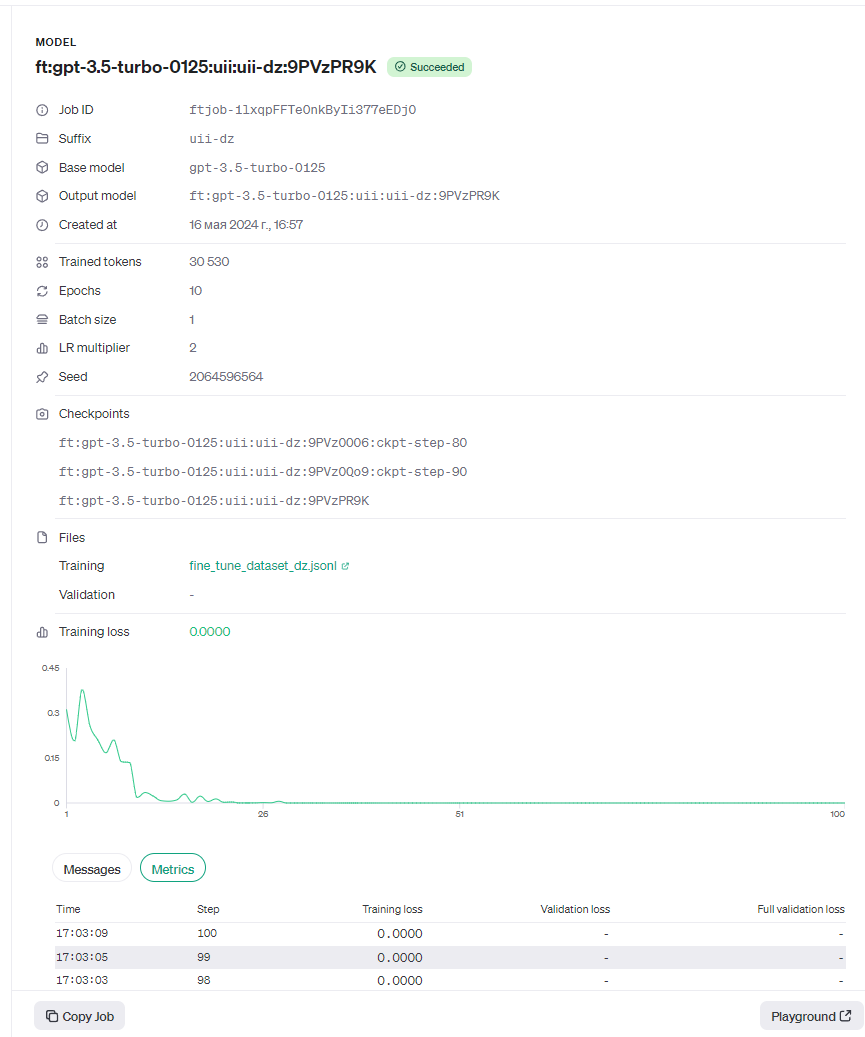

## Использую точно настроенную модель


In [ ]:
system_message = """Укажите следующие поля в JSON словаре: \"Название\", \"Вес\", \"Размер/диагональ\", \"Цвет\", \"Память/накопитель\", \"Процессор\", \"Разрешение\", \"Порты/интерфейсы\", \"Скорость\", and \"Комментарий\"."""

### Пример 1

In [ ]:
question = "Игровая консоль. Вес 3 килограмма, черный цвет, поддержка HDMI и USB, 1 ТБ встроенной памяти, процессор AMD Ryzen, разрешение 4K, скорость загрузки игр до 100 Мбит/с."

completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:uii:uii-dz:9PVzPR9K",
  messages=[
    {"role": "system", "content": system_message},
    {"role": "user", "content": question}
  ],
  temperature=0.0
)
print(completion.choices[0].message.content)
print()
print(f'Токенов на ответ: {completion.usage.completion_tokens}, промпт: {completion.usage.prompt_tokens}, всего: {completion.usage.total_tokens}')

{\"Название\": \"Игровая консоль\", \"Вес\": \"3 кг\", \"Размер/диагональ\": null, \"Цвет\": \"Черный\", \"Память/накопитель\": \"1 ТБ\", \"Процессор\": \"AMD Ryzen\", \"Разрешение\": \"4K\", \"Порты/интерфейсы\": \"HDMI, USB\", \"Скорость\": \"до 100 Мбит/с\", \"Комментарий\": null}

Токенов на ответ: 124, промпт: 173, всего: 297


### Пример 2

In [ ]:
question = "Маршрутизатор для дома. Вес 400 граммов, белый цвет, поддержка Ethernet и Wi-Fi, скорость передачи данных до 1200 Мбит/с, 4 порта LAN, поддержка двойного диапазона."

completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:uii:uii-dz:9PVzPR9K",
  messages=[
    {"role": "system", "content": system_message},
    {"role": "user", "content": question}
  ],
  temperature=0.0
)
print(completion.choices[0].message.content)
print()
print(f'Токенов на ответ: {completion.usage.completion_tokens}, промпт: {completion.usage.prompt_tokens}, всего: {completion.usage.total_tokens}')

{\"Название\": \"Маршрутизатор\", \"Вес\": \"400 г\", \"Размер/диагональ\": null, \"Цвет\": \"Белый\", \"Память/накопитель\": null, \"Процессор\": null, \"Разрешение\": null, \"Порты/интерфейсы\": \"Ethernet, Wi-Fi, 4 порта LAN\", \"Скорость\": \"до 1200 Мбит/с\", \"Комментарий\": null}

Токенов на ответ: 123, промпт: 169, всего: 292


### Пример 3

In [ ]:
question = "Смарт-часы для фитнеса. Вес 50 граммов, черный цвет, 1.5 дюймов экран, поддержка Bluetooth, встроенная память 4 ГБ, процессор Qualcomm, водонепроницаемые. Поддержка GPS и мониторинга сердечного ритма."

completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:uii:uii-dz:9PVzPR9K",
  messages=[
    {"role": "system", "content": system_message},
    {"role": "user", "content": question}
  ],
  temperature=0.0
)
print(completion.choices[0].message.content)
print()
print(f'Токенов на ответ: {completion.usage.completion_tokens}, промпт: {completion.usage.prompt_tokens}, всего: {completion.usage.total_tokens}')

{\"Название\": \"Смарт-часы\", \"Вес\": \"50 г\", \"Размер/диагональ\": \"1.5 дюймов\", \"Цвет\": \"Черный\", \"Память/накопитель\": \"4 ГБ\", \"Процессор\": \"Qualcomm\", \"Разрешение\": null, \"Порты/интерфейсы\": \"Bluetooth\", \"Скорость\": null, \"Комментарий\": \"Водонепроницаемые. Поддержка GPS и мониторинга сердечного ритма\"}

Токенов на ответ: 150, промпт: 195, всего: 345


### Пример использования

In [ ]:
#@title Преобразование json ответа модели в HTML карточку товара

import json
from IPython.display import HTML

# Преобразование JSON в словарь Python
product = json.loads(completion.choices[0].message.content.replace("\\", ""))

# Создание HTML-кода
html_code = f"""
<!DOCTYPE html>
<html>
<head>
    <style>
        .product-card {{
            border: 1px solid #ccc;
            padding: 16px;
            margin: 16px;
            border-radius: 8px;
            max-width: 300px;
            font-family: Arial, sans-serif;
        }}
        .product-title {{
            font-size: 24px;
            margin-bottom: 8px;
            color: #333;
        }}
        .product-details {{
            list-style: none;
            padding: 0;
        }}
        .product-details li {{
            margin-bottom: 4px;
        }}
    </style>
</head>
<body>
    <div class="product-card">
        <h2 class="product-title">{product['Название']}</h2>
        <ul class="product-details">
            <li><strong>Вес:</strong> {product['Вес']}</li>
            <li><strong>Размер/диагональ:</strong> {product['Размер/диагональ'] or '—'}</li>
            <li><strong>Цвет:</strong> {product['Цвет']}</li>
            <li><strong>Память/накопитель:</strong> {product['Память/накопитель'] or '—'}</li>
            <li><strong>Процессор:</strong> {product['Процессор'] or '—'}</li>
            <li><strong>Разрешение:</strong> {product['Разрешение'] or '—'}</li>
            <li><strong>Порты/интерфейсы:</strong> {product['Порты/интерфейсы']}</li>
            <li><strong>Скорость:</strong> {product['Скорость'] or '—'}</li>
            <li><strong>Комментарий:</strong> {product['Комментарий'] or '—'}</li>
        </ul>
    </div>
</body>
</html>
"""

# Отображение HTML
display(HTML(html_code))


## Результат

Всего из 10 примеров составил датасет, обучил модель и применил на практике как инструмент для помощи сотруднику при заполнении карточек товаров.